In [13]:
import os
import sys

script_path = os.path.join(os.getcwd(), "../../Scripts/")
sys.path.append(script_path)
import data_generator as dgen


import matplotlib.pyplot as plt
from datetime import datetime

import torch
import numpy as np
import yaml
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix,
)
from sklearn.metrics import recall_score, accuracy_score, precision_score

import mlflow
from clearml import Task, Logger

# Создаем таску в clearML

In [4]:
import uuid

run_name = f"Run-{uuid.uuid4().hex[:8]}"

task = Task.init(
    project_name="Diploma Conv Net",
    task_name=run_name,
    task_type=Task.TaskTypes.training,
)

task.set_system_tags(["gpu_monitoring"])

ClearML Task: created new task id=87c801bd78e7465bbfb26f11bbd82285
2024-12-04 17:34:26,987 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/7a5fbd80bb434e7793ee7a6217ce42c7/experiments/87c801bd78e7465bbfb26f11bbd82285/output/log


In [5]:
# Примерная функция для нормализации
def normalize(signal):
    return signal - np.mean(signal)


# Класс для подготовки датасета
class ECGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.fixed_length = 5000  # Пример длины для padding

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Берем данные пациента
        ecg_signal = self.data[idx]

        # Применяем нормализацию к каждому каналу
        ecg_signal = np.array([normalize(ch) for ch in ecg_signal])

        # Padding/Truncation до фиксированной длины
        ecg_signal = self._fix_length(ecg_signal)

        # Преобразование в torch.tensor
        ecg_signal = torch.tensor(ecg_signal, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return ecg_signal, label

    def _fix_length(self, ecg_signal):
        # Применяем padding или обрезание
        if ecg_signal.shape[1] < self.fixed_length:
            pad_size = self.fixed_length - ecg_signal.shape[1]
            ecg_signal = np.pad(ecg_signal, ((0, 0), (0, pad_size)), "constant")
        else:
            ecg_signal = ecg_signal[:, : self.fixed_length]
        return ecg_signal


def create_weighted_sampler(labels):
    class_counts = torch.bincount(labels)
    class_weights = 1.0 / class_counts.float()
    sample_weights = class_weights[labels]
    sampler = WeightedRandomSampler(
        weights=sample_weights, num_samples=len(labels), replacement=True
    )
    return sampler


import pickle

with open("../../Data/dumped/X_train.pkl", "rb") as f:
    f.seek(0)
    X_train = pickle.load(f)
with open("../../Data/dumped/y_train.pkl", "rb") as f:
    f.seek(0)
    y_train = pickle.load(f)
with open("../../Data/dumped/X_test.pkl", "rb") as f:
    f.seek(0)
    X_test = pickle.load(f)
with open("../../Data/dumped/y_test.pkl", "rb") as f:
    f.seek(0)
    y_test = pickle.load(f)

print(X_train.shape)
print(y_train.shape)
y_train = np.concatenate([y_train, y_train], axis=1)
Y_train = y_train[0].astype("int8")
Y_test = y_test[0].astype("int8")
# Y_train = F.one_hot(torch.LongTensor(y_train[0]), num_classes=2).double()
# Y_train.double()
# Y_test = F.one_hot(torch.LongTensor(y_test[0]), num_classes=2).double()
# Y_test.double()
# Y_train = y_train[0]
# Y_test = y_test[0]

(190, 8, 5000)
(2, 190)


# Генерируем yaml

In [6]:
import yaml

unique_train, counts_train = np.unique(Y_train, return_counts=True)
unique_test, counts_test = np.unique(Y_test, return_counts=True)
train_dict = dict(zip(unique_train, counts_train))
test_dict = dict(zip(unique_test, counts_test))

# Определяем конфигурацию
config = {
    "model": {
        "architecture": "GroupedInceptionNet",
        "num_channels": 8,
        "num_classes": 2,
        "num_groups": 2,
        "parameters": {"learning_rate": 0.001, "dropout_rate": 0.1},
    },
    "optimizer": {"type": "Adam", "parameters": {"lr": 0.001, "weight_decay": 1e-5}},
    "loss_function": {
        "type": "FocalLoss",
        "parameters": {"alpha": 2.0, "gamma": 3.0, "pos_weight": [1, 4]},
    },
    "dataset": {
        "train_size": 0,
        "test_size": 0,
        "class_distribution": {
            "train": {0: int(train_dict[0]), 1: int(train_dict[1])},
            "test": {0: int(test_dict[0]), 1: int(test_dict[1])},
        },
    },
    "augmentations": {"noise_level": 0.04, "shift_range": 0.2, "mask_prob": 0.3},
}

# Сохраняем в файл
with open("config.yaml", "w") as f:
    yaml.dump(config, f)

In [7]:
class ECGDataAugmentation:
    def __init__(self, noise_level=0.01, shift_range=0.1, mask_prob=0.1):
        """
        Аргументы:
        noise_level (float): Уровень шума, добавляемого к сигналу.
        shift_range (float): Максимальный сдвиг сигнала, выраженный в доле от длины.
        mask_prob (float): Вероятность маскирования случайных интервалов.
        """
        self.noise_level = noise_level
        self.shift_range = shift_range
        self.mask_prob = mask_prob

    def add_noise(self, signal):
        """Добавляем гауссовский шум к сигналу."""
        noise = torch.randn_like(signal) * self.noise_level
        return signal + noise

    def shift_signal(self, signal):
        """Сдвигаем сигнал на случайное значение в пределах shift_range."""
        shift_amount = int(self.shift_range * signal.size(-1))
        shift = np.random.randint(-shift_amount, shift_amount)
        return torch.roll(signal, shifts=shift, dims=-1)

    def mask_random_intervals(self, signal):
        """Маскируем случайные интервалы в сигнале, заменяя их на нули."""
        mask = torch.rand(signal.size()) < self.mask_prob
        signal = signal.masked_fill(mask, 0)
        return signal

    def __call__(self, signal):
        """Применяем все аугментации."""
        signal = self.add_noise(signal)
        signal = self.shift_signal(signal)
        signal = self.mask_random_intervals(signal)
        return signal


data_augmentation = ECGDataAugmentation(
    noise_level=config["augmentations"]["noise_level"],
    shift_range=config["augmentations"]["shift_range"],
    mask_prob=config["augmentations"]["mask_prob"],
)

In [8]:
X_train = np.concatenate(
    [X_train, np.array([data_augmentation(torch.tensor(x)).numpy() for x in X_train])],
    axis=0,
)
print(X_train.shape)
print(y_train.shape)

sampler = create_weighted_sampler(torch.LongTensor(Y_train))
train_dataset = ECGDataset(data=X_train, labels=Y_train)
train_loader = DataLoader(train_dataset, batch_size=2, sampler=sampler)
# train_loader = DataLoader(train_dataset, batch_size=32)

test_dataset = ECGDataset(data=X_test, labels=Y_test)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

config["dataset"]["train_size"] = len(train_dataset)
config["dataset"]["test_size"] = len(test_dataset)

(380, 8, 5000)
(2, 380)


In [9]:
import torch.nn as nn


class GroupedConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups):
        super(GroupedConvBlock, self).__init__()
        self.group_conv = nn.Conv1d(
            in_channels, out_channels, kernel_size=3, padding=1, groups=num_groups
        )
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.group_conv(x)
        x = self.bn(x)
        return self.relu(x)


class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionModule, self).__init__()
        branch_channels = out_channels // 4

        # 1x1 Convolution
        self.branch1 = nn.Conv1d(in_channels, branch_channels, kernel_size=1)

        # 1x1 -> 3x3 Convolution
        self.branch2 = nn.Sequential(
            nn.Conv1d(in_channels, branch_channels, kernel_size=1),
            nn.Conv1d(branch_channels, branch_channels, kernel_size=3, padding=1),
        )

        # 1x1 -> 5x5 Convolution
        self.branch3 = nn.Sequential(
            nn.Conv1d(in_channels, branch_channels, kernel_size=1),
            nn.Conv1d(branch_channels, branch_channels, kernel_size=5, padding=2),
        )

        # Pooling -> 1x1 Convolution
        self.branch4 = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            nn.Conv1d(in_channels, branch_channels, kernel_size=1),
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        return torch.cat([branch1, branch2, branch3, branch4], dim=1)


class GroupedInceptionNet(nn.Module):
    def __init__(self, num_channels=8, num_classes=3, num_groups=4):
        super(GroupedInceptionNet, self).__init__()
        self.input_proj = nn.Conv1d(
            num_channels, 64, kernel_size=1
        )  # Входной проекционный слой

        # Первый блок с grouped convolution
        self.grouped_block = GroupedConvBlock(64, 128, num_groups=num_groups)

        # Inception-модуль
        self.inception_block = InceptionModule(128, 256)

        # Attention-механизм
        self.attention = nn.MultiheadAttention(
            embed_dim=256, num_heads=4, batch_first=True
        )

        # Полносвязные слои
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.drop = nn.Dropout(p=0.3)

    def forward(self, x):
        # Входной проектор
        x = self.input_proj(x)  # [batch_size, 64, seq_len]

        # Grouped Convolution Block
        x = self.grouped_block(x)  # [batch_size, 128, seq_len]

        # Inception Block
        x = self.inception_block(x)  # [batch_size, 256, seq_len]

        # Attention
        x = x.permute(0, 2, 1)  # [batch_size, seq_len, 256]
        x, _ = self.attention(x, x, x)  # [batch_size, seq_len, 256]

        # Усреднение по временной оси
        x = torch.mean(x, dim=1)  # [batch_size, 256]

        # Fully Connected Layers
        x = F.relu(self.drop(self.fc1(x)))
        x = self.fc2(x)  # [batch_size, num_classes]
        return x


# Пример использования
model = GroupedInceptionNet(
    num_channels=config["model"]["num_channels"],
    num_classes=config["model"]["num_classes"],
    num_groups=config["model"]["num_groups"],
)

# test = torch.zeros((16, 8, 5000))
# model = torch.utils.checkpoint.checkpoint_sequential(functions=model, input=test, segments=3)

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss

In [11]:
mlflow.start_run()
torch.cuda.empty_cache()

In [14]:
loss_type = config["loss_function"]["type"]

if loss_type == "FocalLoss":
    criterion = FocalLoss(
        alpha=config["loss_function"]["parameters"]["alpha"],
        gamma=config["loss_function"]["parameters"]["gamma"],
    )
elif loss_type == "BCEWithLogitsLoss":
    pos_weight = torch.tensor(config["loss_function"]["parameters"]["pos_weight"])
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
    raise ValueError(f"Unknown loss function type: {loss_type}")

# criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = FocalLoss(alpha=2, gamma=3)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config["optimizer"]["parameters"]["lr"],
    weight_decay=config["optimizer"]["parameters"]["weight_decay"],
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scaler = torch.amp.GradScaler("cuda")


# Обучение модели
def train_model(model, dataloader, criterion, optimizer, num_epochs=10, patience=10):
    best_valid_loss = float("inf")
    patience_counter = 0

    model.train()
    model.to(device)
    for epoch in range(num_epochs):
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for inputs, labels in dataloader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.amp.autocast("cuda"):
                outputs = model(inputs)
                # labels.type(torch.FloatTensor)

                # labels = labels.type(torch.FloatTensor) \
                #   .reshape((labels.shape[0], 2))epoch_loss

                labels = F.one_hot(labels, num_classes=2).float()

                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * inputs.size(0)
            all_preds.extend(torch.argmax(outputs, dim=1).cpu())
            all_labels.extend(torch.argmax(labels, dim=1).cpu())

        epoch_loss = running_loss / len(dataloader.dataset)
        recall = recall_score(all_labels, all_preds)
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds)

        Logger.current_logger().report_scalar("Accuracy", "Train", accuracy, epoch)
        Logger.current_logger().report_scalar("Loss", "Train", epoch_loss, epoch)
        Logger.current_logger().report_scalar("Recall", "Train", recall, epoch)
        Logger.current_logger().report_scalar("Precision", "Train", precision, epoch)

        mlflow.log_metric("Train Accuracy", accuracy, step=epoch)
        mlflow.log_metric("Train Loss", epoch_loss, step=epoch)
        mlflow.log_metric("Train Recall", recall, step=epoch)
        mlflow.log_metric("Train Precision", precision, step=epoch)

        # if abs(epoch_loss - best_valid_loss) > 0.001:
        #     best_valid_loss = epoch_loss
        #     patience_counter = 0
        # else:
        #     patience_counter += 1
        #     if patience_counter >= patience:
        #         print("Early stopping triggered")
        #         break

        # if epoch_loss < best_valid_loss:
        #     best_valid_loss = epoch_loss
        #     print(f"\nBest validation loss: {best_valid_loss}")
        #     print(f"\nSaving best model for epoch: {epoch+1}\n")
        #     torch.save(model.state_dict(), "model_weights.pth")
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


criterion = criterion.to(device)
# Запуск обучения
train_model(model, train_loader, criterion, optimizer, num_epochs=50)

Epoch 1/50, Loss: 0.1797
Epoch 2/50, Loss: 0.1754
Epoch 3/50, Loss: 0.2086
Epoch 4/50, Loss: 0.1688
Epoch 5/50, Loss: 0.1721
Epoch 6/50, Loss: 0.1733
Epoch 7/50, Loss: 0.1731
Epoch 8/50, Loss: 0.1740
Epoch 9/50, Loss: 0.1653
Epoch 10/50, Loss: 0.1496
Epoch 11/50, Loss: 0.1494
Epoch 12/50, Loss: 0.2100
Epoch 13/50, Loss: 0.1617
Epoch 14/50, Loss: 0.1444
Epoch 15/50, Loss: 0.2412
Epoch 16/50, Loss: 0.1673
Epoch 17/50, Loss: 0.1682
Epoch 18/50, Loss: 0.1761
Epoch 19/50, Loss: 0.1748
Epoch 20/50, Loss: 0.1737
Epoch 21/50, Loss: 0.1730
Epoch 22/50, Loss: 0.1734
Epoch 23/50, Loss: 0.1737
Epoch 24/50, Loss: 0.1735
Epoch 25/50, Loss: 0.1732
Epoch 26/50, Loss: 0.1733
Epoch 27/50, Loss: 0.1732
Epoch 28/50, Loss: 0.1735
Epoch 29/50, Loss: 0.1734
Epoch 30/50, Loss: 0.1732
Epoch 31/50, Loss: 0.1733
Epoch 32/50, Loss: 0.1734
Epoch 33/50, Loss: 0.1734
Epoch 34/50, Loss: 0.1734
Epoch 35/50, Loss: 0.1734


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 36/50, Loss: 0.1733


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 37/50, Loss: 0.1733
Epoch 38/50, Loss: 0.1735
Epoch 39/50, Loss: 0.1735
Epoch 40/50, Loss: 0.1734
Epoch 41/50, Loss: 0.1734
Epoch 42/50, Loss: 0.1734
Epoch 43/50, Loss: 0.1733


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 44/50, Loss: 0.1733


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 45/50, Loss: 0.1734
Epoch 46/50, Loss: 0.1732


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 47/50, Loss: 0.1735
Epoch 48/50, Loss: 0.1733


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 49/50, Loss: 0.1733
Epoch 50/50, Loss: 0.1734


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



In [15]:
# Сохранение модели
torch.save(model.state_dict(), "model_weights.pth")
task.upload_artifact(name="Model Weights", artifact_object="model_weights.pth")

# Сохранение конфигурации
task.upload_artifact(name="Config File", artifact_object="config.yaml")

2024-12-04 17:43:11,071 - clearml.frameworks - INFO - Found existing registered model id=34e14fe384f640f2b495597ab8f0b272 [/home/kravchenko.artem/Projects/Diplomas/Classifiers/Grouped Conv Net/model_weights.pth] reusing it.


True

Validation recall: 0.0000
Validation accuracy: 0.8333
Validation precision: 0.0000

 clasification report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        40
           1       0.00      0.00      0.00         8

    accuracy                           0.83        48
   macro avg       0.42      0.50      0.45        48
weighted avg       0.69      0.83      0.76        48

Матрица несоответствий для тестовой выборки метода ЛДА:



/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-def

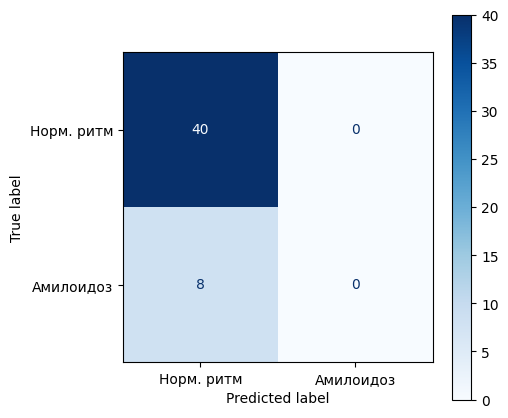

In [16]:
def validate_model(model, dataloader):
    model = GroupedInceptionNet(num_channels=8, num_classes=2, num_groups=config["model"]["num_groups"])
    model.load_state_dict(torch.load("model_weights.pth", weights_only=True))
    model.eval()  # Переводим модель в режим оценки
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Отключаем градиенты для валидации
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Предсказания с максимальной вероятностью
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Преобразуем в numpy массивы
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    # all_labels = np.argmax(all_labels, axis=1)

    # Считаем accuracy
    recall = recall_score(all_labels, all_preds)
    print(f"Validation recall: {recall:.4f}")
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Validation accuracy: {accuracy:.4f}")
    precision = precision_score(all_labels, all_preds)
    print(f"Validation precision: {precision:.4f}")

    class_names = ["Норм. ритм", "Амилоидоз"]

    print("\n clasification report:\n", classification_report(all_labels, all_preds))

    print("Матрица несоответствий для тестовой выборки метода ЛДА:\n")
    fig, ax = plt.subplots(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(
        confusion_matrix(all_labels, all_preds), display_labels=class_names
    )
    disp.plot(cmap="Blues", ax=ax)

    Logger.current_logger().report_confusion_matrix(
        title="Confusion Matrix",
        series="Validation Results",
        matrix=confusion_matrix(all_labels, all_preds),
        yaxis_reversed=True,
        xaxis="Predicted",
        yaxis="Expected",
        xlabels=class_names,
        ylabels=class_names,
    )

    return recall


# Пример вызова валидации
test_accuracy = validate_model(model, test_loader)

In [17]:
mlflow.end_run()
task.close()